# IPL ANALYSIS

### Import all the libraries

In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
os.getcwd()

'C:\\Users\\USER\\Project 1 (IPL)'

### Fetching data from JSON using Python

In [2]:
# Path where JSON files are stored
path = r"C:\Users\USER\Downloads\ipl_json"

# List all json files
files = [f for f in os.listdir(path) if f.endswith('.json')]

print("Total files:", len(files))
print("First 5 files:", files[:5])


Total files: 1169
First 5 files: ['1082591.json', '1082592.json', '1082593.json', '1082594.json', '1082595.json']


In [4]:
with open(os.path.join(path, files[0]), "r") as f:
    data = json.load(f)

print(data.keys())


dict_keys(['meta', 'info', 'innings'])


#### Data 1

In [864]:
all_matches = []

for filename in files:
    with open(os.path.join(path, filename), "r") as f:
        data = json.load(f)
        
        match_id = filename.replace(".json", "")
        season = data["info"].get("season", None)
        teams = data["info"]["teams"]

        # 🧩 Step 1: Identify miscounted overs (if any)
        miscounted_overs = set()
        for inn in data.get("innings", []):
            if "miscounted_overs" in inn:
                for k in inn["miscounted_overs"].keys():
                    miscounted_overs.add(int(k))  # convert string key to int

        target_runs = next(
            (inn["target"]["runs"] for inn in data.get("innings", []) if "target" in inn),
            None
        )

        ball_number = 0
        # Loop through innings
        for i, inning in enumerate(data["innings"], start=1):
            inning_name = f"{i}" if i<3 else "Super Over"
            batting_team = inning["team"]
            bowling_team = [t for t in teams if t != batting_team][0]

            # Loop through overs
            for over in inning["overs"]:
                over_number = over["over"]
                if over_number in miscounted_overs:
                    continue
                    
                legal_ball = 0
                
                # Loop through deliveries
                for delivery in over["deliveries"]:
                    extras_info = delivery.get("extras", {}) or {}

                    # ✅ skip wides and no-balls only
                    is_illegal = any(k in ["wides", "noballs"] for k in extras_info.keys())

                    # count only legal deliveries
                    if not is_illegal:
                        legal_ball += 1
                        ball_number += 1
                        
                    ball_in_over = legal_ball if not is_illegal else None

                    row = {
                        "match_id": match_id,
                        "season": season,
                        "batting_team": batting_team,
                        "bowling_team": bowling_team,
                        "inning": inning_name,
                        "over": over_number,
                        "ball_in_over": ball_in_over,
                        "ball": ball_number,
                        "batsman": delivery["batter"],
                        "non_striker": delivery["non_striker"],
                        "bowler": delivery["bowler"],
                        "runs_batsman": delivery["runs"]["batter"],
                        "runs_extras": delivery["runs"]["extras"],
                        "runs_total": delivery["runs"]["total"],
                        "target_runs": target_runs,
                        "extras_detail": delivery.get("extras", None),
                        "extras_type": list(extras_info.keys())[0] if extras_info else None,
                        "wickets": delivery.get("wickets", None)
                    }
                    all_matches.append(row)

delivery = pd.DataFrame(all_matches)


In [865]:
delivery['season'].unique()

array([2017, '2017', '2018', '2019', '2020/21', '2021', '2022', '2023',
       '2024', '2025', '2007/08', 2009, '2009/10', 2011, 2012, '2012',
       2013, '2013', 2014, 2015, '2015', 2016, '2016'], dtype=object)

In [866]:
import re

def clean_season(val):
    if pd.isna(val):
        return None
    val = str(val)
    x = re.match(r"(\d{4})", val)
    if x:
        return int(x.group(1))
    return None

In [867]:
delivery["season"] = delivery["season"].apply(clean_season)

### Saving & reviewing the fetched data delivery

In [868]:
delivery.sample(3)

,match_id,season,batting_team,bowling_team,inning,over,ball_in_over,ball,batsman,non_striker,bowler,runs_batsman,runs_extras,runs_total,target_runs,extras_detail,extras_type,wickets
186742,501213,2011,Pune Warriors,Delhi Daredevils,1,9,1.0,55,JD Ryder,Yuvraj Singh,S Nadeem,2,0,2,188.0,None,None,None
97506,1359508,2023,Delhi Capitals,Sunrisers Hyderabad,1,15,3.0,93,AR Patel,MK Pandey,Washington Sundar,1,0,1,145.0,None,None,None
260844,829795,2015,Royal Challengers Bangalore,Mumbai Indians,1,16,NaN,101,AB de Villiers,V Kohli,JJ Bumrah,1,1,2,236.0,{'noballs': 1},noballs,None


In [869]:
delivery.shape

(278100, 18)

In [870]:
delivery['ball_in_over'].unique()

array([ 1.,  2.,  3.,  4., nan,  5.,  6.])

In [871]:
delivery.to_csv("ipl_deliveries.csv", index=False)

In [872]:
print("Total rows:", delivery.shape[0])
print("Matches covered:", delivery['match_id'].nunique())
print("Seasons:", delivery['season'].unique())

Total rows: 278100
Matches covered: 1169
Seasons: [2017 2018 2019 2020 2021 2022 2023 2024 2025 2007 2009 2011 2012 2013
 2014 2015 2016]


#### Data 2

In [568]:
matches = []
for filename in files:
    with open(os.path.join(path, filename), "r") as f:
        data = json.load(f)

    # ---- MATCHES DATA ----
    info = data["info"]
    team1, team2 = info.get("teams", [None, None])
    
    matches.append({
        "match_id": filename.replace(".json", ""),
        "season": info.get("season"),
        "city": info.get("city"),
        "venue": info.get("venue"),
        "dates": info.get("dates"),
        "team1": team1,
        "team2": team2,
        "toss_winner": info["toss"].get("winner"),
        "toss_decision": info["toss"].get("decision"),
        "player_of_match": ", ".join(info.get("player_of_match") or []),
        "umpire1": (info.get("officials", {}).get("umpires") or info.get("umpires") or [None, None])[0],
        "umpire2": (info.get("officials", {}).get("umpires") or info.get("umpires") or [None, None])[1],
        "result": (
            f"{info['outcome']['winner']} won by {info['outcome']['by']['runs']} runs"
                if "runs" in info.get("outcome", {}).get("by", {}) else
            f"{info['outcome']['winner']} won by {info['outcome']['by']['wickets']} wickets"
                if "wickets" in info.get("outcome", {}).get("by", {}) else
            "No Result"
        ),
        "winner": info.get("outcome", {}).get("winner"),
        "by_runs": info.get("outcome", {}).get("by", {}).get("runs", 0),
        "by_wickets": info.get("outcome", {}).get("by", {}).get("wickets")
    })
    match=pd.DataFrame(matches)

In [569]:
match['season'] = match['season'].apply(clean_season)

### Saving & reviewing the fetched data matches

In [570]:
match.to_csv('ipl_matches.csv', index = False)

In [571]:
print("Total rows:", match.shape[0])
print("Matches covered:", match['match_id'].nunique())
print("Seasons:", match['season'].unique())

Total rows: 1169
Matches covered: 1169
Seasons: [2017 2018 2019 2020 2021 2022 2023 2024 2025 2007 2009 2011 2012 2013
 2014 2015 2016]


<b>So here we have dataset of both matches and ball by ball delivery of what happens at which ball.<br>
Now we can Exploratory data analysis and plot the graph of different comparisons.</b>

---

#### Sample of both datasets

In [572]:
match.sample()

,match_id,season,city,venue,dates,team1,team2,toss_winner,toss_decision,player_of_match,umpire1,umpire2,result,winner,by_runs,by_wickets
543,1473463,2025,Lucknow,Bharat Ratna Shri Atal Bihari Vajpayee Ekana C...,[2025-04-12],Gujarat Titans,Lucknow Super Giants,Lucknow Super Giants,field,AK Markram,K Swaroopanand,UV Gandhe,Lucknow Super Giants won by 6 wickets,Lucknow Super Giants,0,6.0


In [573]:
delivery.sample()

,match_id,season,batting_team,inning,over,ball_in_over,ball,batsman,non_striker,bowler,runs_batsman,runs_extras,runs_total,extras_detail,extras_type,wickets
276538,981007,2016,Gujarat Lions,2,1,2.0,128,BB McCullum,SK Raina,JJ Bumrah,0,0,0,None,None,None


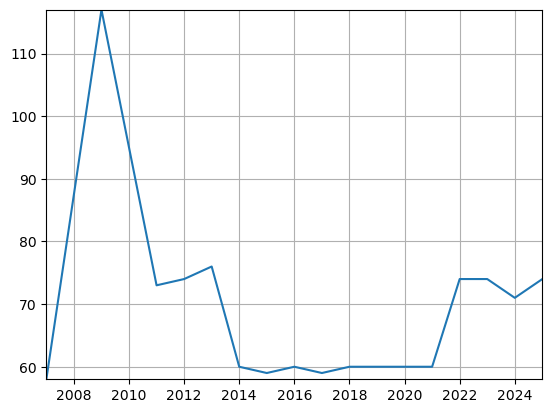

In [21]:
# Total matches per season

matches_per_season = match.groupby('season').size().reset_index(name='count')
plt.plot(matches_per_season['season'], matches_per_season['count'])
plt.autoscale(enable=True, axis='both', tight=True)
plt.grid()
plt.show()

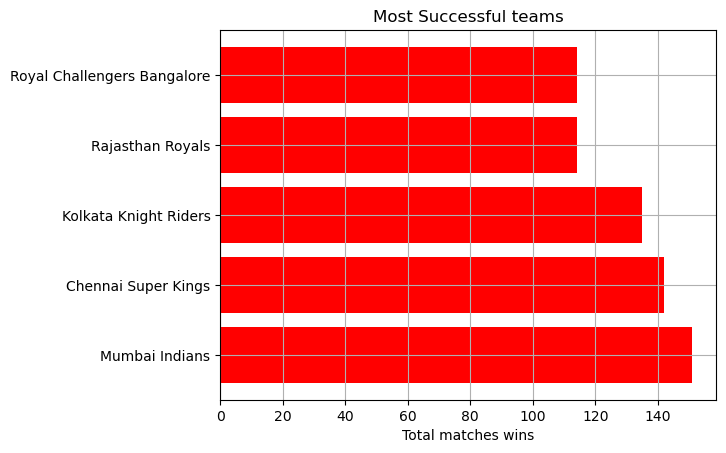

In [22]:
# Most successful team

most_wins= match['winner'].value_counts().head(5).reset_index(name='count')
plt.barh(most_wins['winner'], most_wins['count'], color='red')
plt.title('Most Successful teams')
plt.xlabel('Total matches wins')
plt.grid()
plt.show()

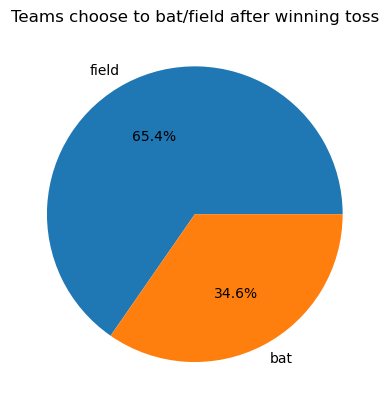

In [23]:
# toss decision is batting or bowling

toss_choice = match['toss_decision'].value_counts().reset_index(name='count')
plt.pie(toss_choice['count'], labels=toss_choice['toss_decision'], autopct='%1.1f%%')
plt.title('Teams choose to bat/field after winning toss')
plt.show()

In [24]:
delivery.sample()

,match_id,season,batting_team,over,batsman,non_striker,bowler,runs_batsman,runs_extras,runs_total,extras_detail,wickets
105228,1359540,2023,Rajasthan Royals,11,SO Hetmyer,YBK Jaiswal,Arshdeep Singh,0,1,1,{'wides': 1},None


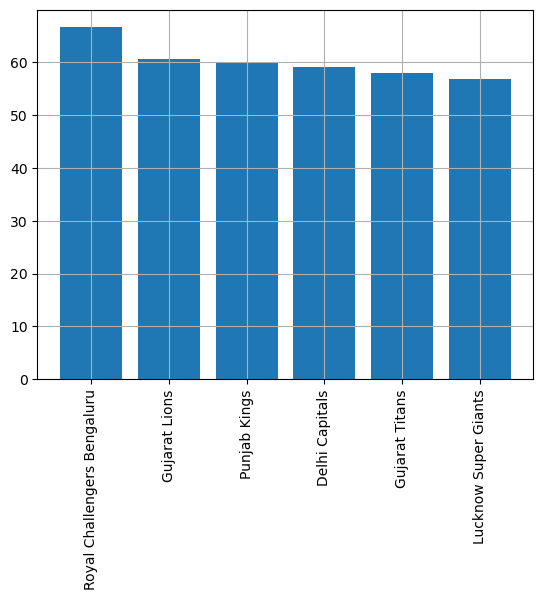

In [25]:
# Average powerplay runs (overs 1–6) by teams

overs = delivery[delivery['over'] <7]
powerplay_runs=overs.groupby(['match_id', 'batting_team'])['runs_total'].sum().groupby('batting_team').mean().sort_values(ascending=False).head(6).reset_index()
plt.bar(powerplay_runs['batting_team'], powerplay_runs['runs_total'])
plt.xticks(rotation='vertical')
plt.grid()
plt.show()

In [26]:
# Find the orange cap of every year (who scored maximum runs)

new =delivery.merge(match, left_on ='match_id', right_on ='match_id')
new = new.drop(columns=['season_x']).rename(columns={'season_y': 'season'})

In [27]:
orange_cap=(new.groupby(['season', 'batsman'])['runs_batsman'].sum()
    .sort_values(ascending=False).reset_index()
    .drop_duplicates(subset='season', keep='first')
    .sort_values('season'))
orange_cap

,season,batsman,runs_batsman
43,2007,SE Marsh,616
0,2009,SR Tendulkar,982
44,2011,CH Gayle,608
14,2012,CH Gayle,733
13,2013,MEK Hussey,733
27,2014,RV Uthappa,660
63,2015,DA Warner,562
1,2016,V Kohli,973
31,2017,DA Warner,641
12,2018,KS Williamson,735


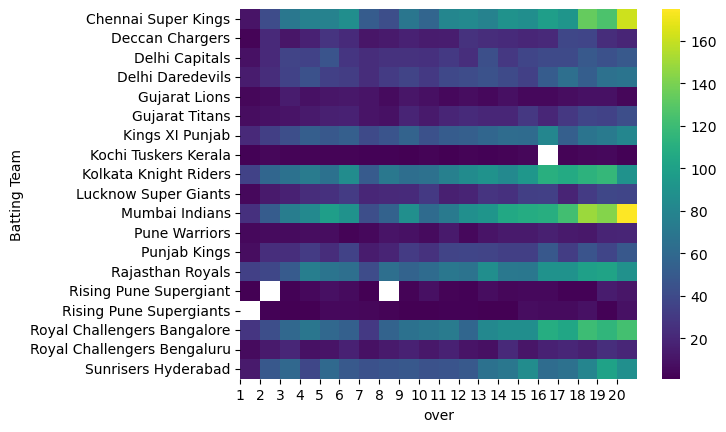

In [28]:
# Most sixes in which over

six =delivery[delivery['runs_batsman'] ==6]
graph =six.pivot_table(index ='over', columns='batting_team', values='runs_total', aggfunc ='count')

sns.heatmap(graph.T, cmap ='viridis')
plt.ylabel('Batting Team')
plt.xticks(ticks=range(20), labels=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.show()

### Observation
<ul>
    <li>Number of matches are highest in 2008 and 2009 and dropped then. In past 3 years average matches per season is 75</li>
    <li>Mumbai Indians and Chennai Super Kings have most wins means they are consistently strong teams</li>
    <li>Most teams choose fielding first even after winnning toss for reasons like
    <ul>
        <li>Chasing is usually considered easier (teams know the target).</li>
        <li>Due factors like dew at night, bowling becomes harder later, so captains prefer chasing.</li>
        <li>Short format (20 overs) → batting second allows more controlled aggression.</li>
    </ul></li>
    <li>RCB starts well in almost every match because their powerplay is best among all teams</li>
    <li>CSK and MI are most volatile teams in last 3 overs as they have highest number of sixes in last overs.</li>
</ul>

---

---

In [982]:
ipl = delivery.merge(match,on ='match_id')
ipl.columns

Index(['match_id', 'season_x', 'batting_team', 'bowling_team', 'inning',
       'over', 'ball_in_over', 'ball', 'batsman', 'non_striker', 'bowler',
       'runs_batsman', 'runs_extras', 'runs_total', 'target_runs',
       'extras_detail', 'extras_type', 'wickets', 'season_y', 'city', 'venue',
       'dates', 'team1', 'team2', 'toss_winner', 'toss_decision',
       'player_of_match', 'umpire1', 'umpire2', 'result', 'winner', 'by_runs',
       'by_wickets'],
      dtype='object')

In [983]:
ipl = ipl.drop(columns=['season_y']).rename(columns ={'season_x':'season'})
ipl.columns

Index(['match_id', 'season', 'batting_team', 'bowling_team', 'inning', 'over',
       'ball_in_over', 'ball', 'batsman', 'non_striker', 'bowler',
       'runs_batsman', 'runs_extras', 'runs_total', 'target_runs',
       'extras_detail', 'extras_type', 'wickets', 'city', 'venue', 'dates',
       'team1', 'team2', 'toss_winner', 'toss_decision', 'player_of_match',
       'umpire1', 'umpire2', 'result', 'winner', 'by_runs', 'by_wickets'],
      dtype='object')

In [984]:
ipl.sample(2)

,match_id,season,batting_team,bowling_team,inning,over,ball_in_over,ball,batsman,non_striker,...,team2,toss_winner,toss_decision,player_of_match,umpire1,umpire2,result,winner,by_runs,by_wickets
44100,1216498,2020,Sunrisers Hyderabad,Kings XI Punjab,2,15,2.0,212,MK Pandey,V Shankar,...,Sunrisers Hyderabad,Sunrisers Hyderabad,field,CJ Jordan,AY Dandekar,PR Reiffel,Kings XI Punjab won by 12 runs,Kings XI Punjab,12,NaN
73482,1304055,2022,Rajasthan Royals,Mumbai Indians,1,19,5.0,119,R Parag,TA Boult,...,Mumbai Indians,Mumbai Indians,field,JC Buttler,Nitin Menon,PG Pathak,Rajasthan Royals won by 23 runs,Rajasthan Royals,23,NaN


In [985]:
ipl.rename(columns={'runs_total' : 'runs_in_ball'}, inplace = True)

In [986]:
ipl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278100 entries, 0 to 278099
Data columns (total 32 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   match_id         278100 non-null  object 
 1   season           278100 non-null  int64  
 2   batting_team     278100 non-null  object 
 3   bowling_team     278100 non-null  object 
 4   inning           278100 non-null  object 
 5   over             278100 non-null  int64  
 6   ball_in_over     267868 non-null  float64
 7   ball             278100 non-null  int64  
 8   batsman          278100 non-null  object 
 9   non_striker      278100 non-null  object 
 10  bowler           278100 non-null  object 
 11  runs_batsman     278100 non-null  int64  
 12  runs_extras      278100 non-null  int64  
 13  runs_in_ball     278100 non-null  int64  
 14  target_runs      277605 non-null  float64
 15  extras_detail    15121 non-null   object 
 16  extras_type      15121 non-null   obje

In [987]:
print(ipl['over'].unique())
print('Shape of our dataset :', ipl.shape)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Shape of our dataset : (278100, 32)


In [988]:
ipl["inning"].apply(type).value_counts()

inning
<class 'str'>    278100
Name: count, dtype: int64

In [989]:
total_score_ipl = ipl.groupby(['match_id', 'inning'])['runs_in_ball'].sum().reset_index()
total_score_ipl

,match_id,inning,runs_in_ball
0,1082591,1,207
1,1082591,2,172
2,1082592,1,184
3,1082592,2,187
4,1082593,1,183
...,...,...,...
2343,981015,2,140
2344,981017,1,162
2345,981017,2,163
2346,981019,1,208


In [990]:
ipl = ipl[ipl['inning'] == '2']

In [991]:
ipl['team1'].unique()

array(['Sunrisers Hyderabad', 'Rising Pune Supergiant', 'Gujarat Lions',
       'Kings XI Punjab', 'Royal Challengers Bangalore', 'Mumbai Indians',
       'Kolkata Knight Riders', 'Delhi Daredevils', 'Rajasthan Royals',
       'Chennai Super Kings', 'Delhi Capitals', 'Punjab Kings',
       'Lucknow Super Giants', 'Gujarat Titans',
       'Royal Challengers Bengaluru', 'Deccan Chargers',
       'Kochi Tuskers Kerala', 'Pune Warriors', 'Rising Pune Supergiants'],
      dtype=object)

In [992]:
team =['Sunrisers Hyderabad',
       'Mumbai Indians',
       'Kolkata Knight Riders', 
       'Rajasthan Royals',
       'Chennai Super Kings',
       'Delhi Capitals',
       'Punjab Kings',
       'Lucknow Super Giants', 
       'Gujarat Titans',
       'Royal Challengers Bengaluru'
      ]

In [993]:
ipl['team1'] = ipl['team1'].str.replace('Delhi Daredevils', 'Delhi Capitals')
ipl['team2'] = ipl['team2'].str.replace('Delhi Daredevils', 'Delhi Capitals')

ipl['team1'] = ipl['team1'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')
ipl['team2'] = ipl['team2'].str.replace('Deccan Chargers', 'Sunrisers Hyderabad')

ipl['team1'] = ipl['team1'].str.replace('Kings XI Punjab', 'Punjab Kings')
ipl['team2'] = ipl['team2'].str.replace('Kings XI Punjab', 'Punjab Kings')

ipl['team1'] = ipl['team1'].str.replace('Gujarat Lions', 'Gujarat Titans')
ipl['team2'] = ipl['team2'].str.replace('Gujarat Lions', 'Gujarat Titans')

ipl['team1'] = ipl['team1'].str.replace('Royal Challengers Bangalore', 'Royal Challengers Bengaluru')
ipl['team2'] = ipl['team2'].str.replace('Royal Challengers Bangalore', 'Royal Challengers Bengaluru')

In [994]:
ipl = ipl[ipl['team1'].isin(team)]
ipl = ipl[ipl['team2'].isin(team)]

In [995]:
ipl['team1'].nunique()

10

In [996]:
ipl.columns

Index(['match_id', 'season', 'batting_team', 'bowling_team', 'inning', 'over',
       'ball_in_over', 'ball', 'batsman', 'non_striker', 'bowler',
       'runs_batsman', 'runs_extras', 'runs_in_ball', 'target_runs',
       'extras_detail', 'extras_type', 'wickets', 'city', 'venue', 'dates',
       'team1', 'team2', 'toss_winner', 'toss_decision', 'player_of_match',
       'umpire1', 'umpire2', 'result', 'winner', 'by_runs', 'by_wickets'],
      dtype='object')

In [997]:
ipl['curr_score'] = ipl.groupby('match_id')['runs_in_ball'].cumsum()
ipl['runs_left'] = ipl['target_runs'] - ipl['curr_score']

In [998]:
ipl.sample(3)

,match_id,season,batting_team,bowling_team,inning,over,ball_in_over,ball,batsman,non_striker,...,toss_decision,player_of_match,umpire1,umpire2,result,winner,by_runs,by_wickets,curr_score,runs_left
182328,419162,2009,Royal Challengers Bangalore,Mumbai Indians,2,4,1.0,145,R Dravid,KP Pietersen,...,bat,KA Pollard,BR Doctrove,RB Tiffin,Mumbai Indians won by 35 runs,Mumbai Indians,35,NaN,32,153.0
129554,1473459,2025,Chennai Super Kings,Punjab Kings,2,13,5.0,203,S Dube,DP Conway,...,bat,Priyansh Arya,Abhijit Bhattacharya,UV Gandhe,Punjab Kings won by 18 runs,Punjab Kings,18,NaN,138,82.0
38785,1178419,2019,Chennai Super Kings,Mumbai Indians,2,16,2.0,218,DL Chahar,MJ Santner,...,field,RG Sharma,AK Chaudhary,NJ Llong,Mumbai Indians won by 46 runs,Mumbai Indians,46,NaN,100,56.0


In [999]:
ipl['balls_left'] = 120 - ((ipl['over'])*6 + ipl['ball_in_over'])
ipl.sample(2)

,match_id,season,batting_team,bowling_team,inning,over,ball_in_over,ball,batsman,non_striker,...,player_of_match,umpire1,umpire2,result,winner,by_runs,by_wickets,curr_score,runs_left,balls_left
200336,548306,2012,Mumbai Indians,Chennai Super Kings,2,16,4.0,219,JEC Franklin,AT Rayudu,...,RE Levi,JD Cloete,SJA Taufel,Mumbai Indians won by 8 wickets,Mumbai Indians,0,8.0,109,4.0,20.0
227558,598037,2013,Kings XI Punjab,Mumbai Indians,2,19,5.0,239,P Kumar,P Awana,...,RG Sharma,Asad Rauf,AK Chaudhary,Mumbai Indians won by 4 runs,Mumbai Indians,4,NaN,170,5.0,1.0


In [1000]:
ipl.columns

Index(['match_id', 'season', 'batting_team', 'bowling_team', 'inning', 'over',
       'ball_in_over', 'ball', 'batsman', 'non_striker', 'bowler',
       'runs_batsman', 'runs_extras', 'runs_in_ball', 'target_runs',
       'extras_detail', 'extras_type', 'wickets', 'city', 'venue', 'dates',
       'team1', 'team2', 'toss_winner', 'toss_decision', 'player_of_match',
       'umpire1', 'umpire2', 'result', 'winner', 'by_runs', 'by_wickets',
       'curr_score', 'runs_left', 'balls_left'],
      dtype='object')

In [1001]:
ipl['wickets'].isna().value_counts()

wickets
True     117711
False      6136
Name: count, dtype: int64

In [1002]:
ipl['wickets'] = ipl['wickets'].fillna("0")
ipl['wickets'] = ipl['wickets'].apply(lambda x:x if x == "0" else "1")
ipl['wickets'] = ipl['wickets'].astype(int)

In [1003]:
ipl['wickets_left'] = 10 - ipl.groupby('match_id')['wickets'].cumsum()

In [1004]:
import numpy as np
ipl['crr'] = ipl['curr_score']/((ipl['over'])*6 + ipl['ball_in_over'])
ipl['rrr'] = np.where(
    ipl["balls_left"] > 0,
    (ipl["runs_left"] ) / ipl["balls_left"],  # required run rate per over
    0  # when no balls left, set RRR = 0
)

In [1005]:
cols = list(ipl.columns)
cols.remove("target_runs")
cols.insert(28, "target_runs")
ipl = ipl[cols]

In [1006]:
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

In [1007]:
ipl['resultant'] = ipl.apply(result, axis=1)

In [1008]:
ipl.sample(3)

,match_id,season,batting_team,bowling_team,inning,over,ball_in_over,ball,batsman,non_striker,...,winner,by_runs,by_wickets,curr_score,runs_left,balls_left,wickets_left,crr,rrr,resultant
104247,1359536,2023,Sunrisers Hyderabad,Gujarat Titans,2,16,3.0,219,H Klaasen,B Kumar,...,Gujarat Titans,34,NaN,126,63.0,21.0,3,1.272727,3.000000,0
118334,1426284,2024,Sunrisers Hyderabad,Chennai Super Kings,2,3,5.0,143,Abhishek Sharma,AK Markram,...,Chennai Super Kings,78,NaN,40,173.0,97.0,7,1.739130,1.783505,0
106405,1370350,2023,Gujarat Titans,Chennai Super Kings,2,2,6.0,138,WP Saha,Shubman Gill,...,Chennai Super Kings,15,NaN,22,151.0,102.0,9,1.222222,1.480392,0


In [1009]:
ipl.columns

Index(['match_id', 'season', 'batting_team', 'bowling_team', 'inning', 'over',
       'ball_in_over', 'ball', 'batsman', 'non_striker', 'bowler',
       'runs_batsman', 'runs_extras', 'runs_in_ball', 'extras_detail',
       'extras_type', 'wickets', 'city', 'venue', 'dates', 'team1', 'team2',
       'toss_winner', 'toss_decision', 'player_of_match', 'umpire1', 'umpire2',
       'result', 'target_runs', 'winner', 'by_runs', 'by_wickets',
       'curr_score', 'runs_left', 'balls_left', 'wickets_left', 'crr', 'rrr',
       'resultant'],
      dtype='object')

In [1010]:
ipl['venue']

125       Rajiv Gandhi International Stadium, Uppal
126       Rajiv Gandhi International Stadium, Uppal
127       Rajiv Gandhi International Stadium, Uppal
128       Rajiv Gandhi International Stadium, Uppal
129       Rajiv Gandhi International Stadium, Uppal
                            ...                    
278095                        M Chinnaswamy Stadium
278096                        M Chinnaswamy Stadium
278097                        M Chinnaswamy Stadium
278098                        M Chinnaswamy Stadium
278099                        M Chinnaswamy Stadium
Name: venue, Length: 123847, dtype: object

In [1011]:
# Fill missing city values using venue
ipl["city"] = ipl["city"].fillna(ipl["venue"])

# If still missing, fill with 'Unknown'
ipl["city"].fillna("Unknown", inplace=True)

# Fill numeric nulls
ipl["balls_left"].fillna(0, inplace=True)
ipl["crr"].fillna(0, inplace=True)

# RRR = 0 if chase finished (runs_left <= 0)
ipl.loc[ipl["runs_left"] <= 0, "rrr"] = 0
ipl["rrr"].fillna(0, inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_1884\2608901892.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ipl["city"].fillna("Unknown", inplace=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_1884\2608901892.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

In [1012]:
finaldata= ipl[['batting_team', 'bowling_team',
     'city','target_runs',
     'runs_left', 'balls_left',
     'wickets_left', 
     'crr', 'rrr', 'resultant'
    ]]

In [1013]:
# Suffle the data
finaldata = finaldata.sample(finaldata.shape[0])
finaldata.head(6)

,batting_team,bowling_team,city,target_runs,runs_left,balls_left,wickets_left,crr,rrr,resultant
24555,Royal Challengers Bangalore,Delhi Daredevils,Delhi,182.0,29.0,23.0,6,1.577320,1.260870,1
156199,Kolkata Knight Riders,Kings XI Punjab,Durban,69.0,10.0,85.0,9,1.685714,0.117647,1
102306,Mumbai Indians,Royal Challengers Bangalore,Mumbai,200.0,159.0,98.0,10,1.863636,1.622449,1
126386,Mumbai Indians,Gujarat Titans,Ahmedabad,197.0,189.0,117.0,10,2.666667,1.615385,0
142668,Kolkata Knight Riders,Deccan Chargers,Kolkata,111.0,93.0,101.0,8,0.947368,0.920792,1
236995,Rajasthan Royals,Sunrisers Hyderabad,Abu Dhabi,134.0,26.0,24.0,6,1.125000,1.083333,1


In [1014]:
finaldata.isnull().sum()

batting_team    0
bowling_team    0
city            0
target_runs     0
runs_left       0
balls_left      0
wickets_left    0
crr             0
rrr             0
resultant       0
dtype: int64

---

### As we have done all the data cleaning now is the time of building our model and do a train_test_split on that

In [1015]:
X = finaldata.iloc[:, :-1]
y = finaldata.iloc[:, -1]

from sklearn.model_selection import train_test_split

In [1016]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1)

In [1017]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [1018]:
trf = ColumnTransformer([
    ('trf', OneHotEncoder(sparse_output=False,drop='first'),['batting_team','bowling_team', 'city'])
],
remainder='passthrough')

In [1019]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [1020]:
pipe = Pipeline(steps=[
    ('step1',trf),
    ('step2',LogisticRegression(solver='liblinear'))
])

In [1021]:
pipe.fit(X_train, y_train)

,steps,"[('step1', ...), ('step2', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('trf', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [1023]:
y_pred = pipe.predict(X_test)

In [1024]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.8081953976584578

In [1027]:
pipe.predict_proba(X_test)[123]*100

array([76.44835309, 23.55164691])

In [1037]:
team

['Sunrisers Hyderabad',
 'Mumbai Indians',
 'Kolkata Knight Riders',
 'Rajasthan Royals',
 'Chennai Super Kings',
 'Delhi Capitals',
 'Punjab Kings',
 'Lucknow Super Giants',
 'Gujarat Titans',
 'Royal Challengers Bengaluru']

In [1038]:
ipl.sample()

,match_id,season,batting_team,bowling_team,inning,over,ball_in_over,ball,batsman,non_striker,...,winner,by_runs,by_wickets,curr_score,runs_left,balls_left,wickets_left,crr,rrr,resultant
259695,829785,2015,Kings XI Punjab,Royal Challengers Bangalore,2,2,3.0,135,GJ Maxwell,WP Saha,...,Royal Challengers Bangalore,138,NaN,19,208.0,105.0,8,1.266667,1.980952,0


In [1039]:
ipl['city'].unique()

array(['Hyderabad', 'Rajkot', 'Bengaluru', 'Mumbai', 'Indore', 'Kolkata',
       'Bangalore', 'Delhi', 'Chandigarh', 'Kanpur', 'Chennai', 'Jaipur',
       'Pune', 'Visakhapatnam', 'Abu Dhabi',
       'Dubai International Cricket Stadium', 'Sharjah Cricket Stadium',
       'Ahmedabad', 'Sharjah', 'Dubai', 'Navi Mumbai', 'Lucknow',
       'Guwahati', 'Dharamsala', 'Mohali', 'New Chandigarh', 'Cape Town',
       'Port Elizabeth', 'Durban', 'Centurion', 'East London',
       'Johannesburg', 'Kimberley', 'Bloemfontein', 'Cuttack', 'Nagpur',
       'Raipur', 'Ranchi'], dtype=object)

In [1040]:
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))

In [1043]:
ipl['city'].unique()

array(['Hyderabad', 'Rajkot', 'Bengaluru', 'Mumbai', 'Indore', 'Kolkata',
       'Bangalore', 'Delhi', 'Chandigarh', 'Kanpur', 'Chennai', 'Jaipur',
       'Pune', 'Visakhapatnam', 'Abu Dhabi',
       'Dubai International Cricket Stadium', 'Sharjah Cricket Stadium',
       'Ahmedabad', 'Sharjah', 'Dubai', 'Navi Mumbai', 'Lucknow',
       'Guwahati', 'Dharamsala', 'Mohali', 'New Chandigarh', 'Cape Town',
       'Port Elizabeth', 'Durban', 'Centurion', 'East London',
       'Johannesburg', 'Kimberley', 'Bloemfontein', 'Cuttack', 'Nagpur',
       'Raipur', 'Ranchi'], dtype=object)